In [62]:
import numpy as np
import matplotlib.pyplot as plt

# generate SEM
import sys
sys.path.append("..")

from notears.notears.notears import linear
from notears.notears.notears import utils
import helper.helper as h
import helper.methods as m

from importlib import reload  # Python 3.4+

True W:
[[ 0.    0.   -0.78]
 [-0.88  0.   -0.77]
 [ 0.    0.    0.  ]].



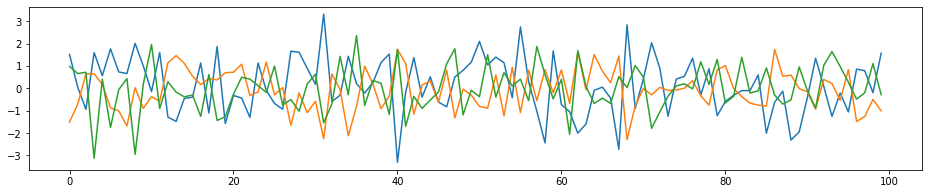

In [103]:
# set random seed
# utils.set_random_seed(1)

# print W
T, p, s0, graph_type, sem_type = 100, 3, 3, 'ER', 'gauss'
W_true = utils.simulate_parameter(utils.simulate_dag(p, s0, graph_type), w_ranges = ((-1.0, -0.75), (0.75, 1.0)))
print(f"True W:\n{np.round(W_true, 2)}.\n")

# plot X
X = utils.simulate_linear_sem(W_true, T, sem_type)
plt.figure(figsize=(16, 3))
plt.plot(X);

# zero - mean
X_a = X - np.mean(X, axis = 0)

In [66]:
X_norm = np.sum(X.T ** 2, axis = -1)
Psi = np.exp(-(X_norm[None, :] + X_norm[:, None] - 2 * np.dot(X.T, X)) / 2)
print(Psi)

print([RBF(X[:, i], Y[:, j], 1e3) for i in range(n) for j in range(n)])
# K = np.exp(-(X_norm[:,None] + X_norm[None,:] - 2 * np.dot(X, X.T)) / 2)
# print(K)

[[1.00000000e+00 5.77751404e-36 4.01750748e-36]
 [5.77751404e-36 1.00000000e+00 5.98913503e-35]
 [4.01750748e-36 5.98913503e-35 1.00000000e+00]]
[0.4626785268144463, 0.4626785268144463, 0.4626785268144463, 0.4606683703513653, 0.4606683703513653, 0.4606683703513653, 0.463260591743532, 0.463260591743532, 0.463260591743532]


In [65]:
def RBF(i, j, s = 1):
    return np.exp(-np.linalg.norm(i - j, 2) ** 2 / (2 * s))

T = 1000
X = np.random.rand(T, n)
X -= np.mean(X, axis = 0)
W = np.array(np.ones(n ** 2)).reshape(n, n)
Y = np.exp(X @ W)

In [67]:
print([RBF(X[:, i], Y[:, j], 1e3) for i in range(n) for j in range(n)])

[0.4626785268144463, 0.4626785268144463, 0.4626785268144463, 0.4606683703513653, 0.4606683703513653, 0.4606683703513653, 0.463260591743532, 0.463260591743532, 0.463260591743532]


In [68]:
def KOMP_Psi_K(Psi, K, max_coefs = 1e10, tol = 0.0, verbose = False, output = False, normalize = True, gamma = 1e-3):
    """Do Kernel OMP on X, Y."""
    
    # get dimensions
    T, n = np.shape(X)
    
    F = [i * (n + 1) for i in range(n)]
    
    X_norm = np.sum(X.T ** 2, axis = -1)
    Y_norm = np.sum(Y.T ** 2, axis = -1)
    
    # compute kernel spaces
    Psi = np.exp(- gamma * (X_norm[None, :] + X_norm[:, None] - 2 * np.dot(X.T, X)) / 2)
    K = np.exp(- gamma * (X_norm[None, :] + Y_norm[:, None] - 2 * np.dot(X.T, Y)) / 2)
    
    Theta = [y.T.dot(y) for y in Y.T]   # 1 times 1

    # initialize Lambda, idx, betas
    Lambda, idx, betas = [[] for _ in range(n)], [], np.zeros((n, n))

    # compute norms if we want to normalize
    norms = [1] * n # initialize as harmless 1 array
    if normalize: norms = [np.linalg.norm(x) for x in X.T]
    
    # for each possible coefficient
    for i in range(n ** 2):    
    
        # compute gains
        gains = np.abs([(k - betas.T @ Psi[i, :]) / norms[i] for i, k in enumerate(K)])
        
        # stopping criterion
        if np.round(gains, 5).max() <= tol: 
            print("Break")
            break
    
        # append best atom to Lambda
        # if tie, pick the one that minimizes residual
        row, col = np.argmax(gains) // n, np.argmax(gains) % n
        Lambda[col].append(row)
    
        # check if we have a DAG, not super efficient
        if True: # h.is_dag(Lambda_to_adj(Lambda)): 
            # update only column col, use indices of 
            idx = Lambda[col]
            Psi_F = Psi[np.array(idx)[:, None], np.array(idx)[None, :]]
        
            # update betas
            betas[np.array(idx)[:, None], col] = np.linalg.inv(Psi_F) @ K[np.array(idx)[:, None], col]
    
        else:
            # append forbidden entry to forbidden list
            F.append(int(np.argmax(gains)))
            # remove coefficient from Lambda
            Lambda[col].remove(row)
    
        # print info if verbose
        if verbose:
            print(f"Iteration {i + 1}.\n")
            print(f"Gains:\n{np.round(gains, 3)}.\n")
            print(f"Beta_{i + 1}:\n{np.round(betas, 3)}.\n")
            print(f"Residual Squared: {np.round([Theta[i] - Psi[:, i] @ betas[:, i] for i in range(n)], 32)}.\n\n")

    return betas 

print(np.round(KOMP(X, Y, gamma = 1e-5), 2))

NameError: name 'KOMP' is not defined

### Quadratic Kernel

In [81]:
def _phi(x):
    
    T = np.shape(X)[0]

    arr = np.zeros(int(T + (T * (T + 1) / 2)))
    
    arr[:T] = x ** 2
    
    count = T
    
    for i in range(T):
        for j in range(i):
            arr[count] = np.sqrt(2) * x[i] * x[j]
            
            count += 1
            
    return arr

T = 10
X = np.random.rand(T)
print(np.dot(_phi(X), _phi(X.T)))
print(np.dot(X.T, X) ** 2)

9.95099601407681
9.950996014076813


In [82]:
def _phi_all(x):
    X_phi = np.zeros((p, p))
    
    for i in range(p):
        for j in range(p):
            X_phi[i][j] = np.dot(_phi(X[:, i]), _phi(X[:, j].T))
    
    return X_phi

n, T = p, 10
X = np.random.rand(T, p)
print(_phi_all(X))
print(np.dot(X.T, X) ** 2)

[[1.94871048 1.50021534 1.60480364]
 [1.50021534 9.71491354 4.84475935]
 [1.60480364 4.84475935 6.59520766]]
[[1.94871048 1.50021534 1.60480364]
 [1.50021534 9.71491354 4.84475935]
 [1.60480364 4.84475935 6.59520766]]


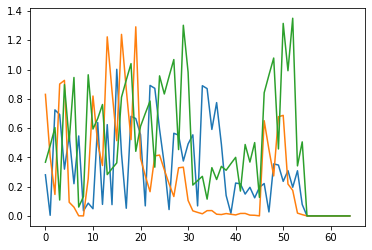

In [71]:
# transform X and Y
X_phi = np.zeros((int(T + (T * (T + 1) / 2)), p))

for i in range(n):
    X_phi[:, i] = _phi(X[:, i])
    
plt.plot(X_phi)

# 1D

#### Quadratic Kernel
The quadratic kernel is without offset is defined as $K(x, y) = (x^Ty)^2$.

When writing this out, we can see that this is an inner product of the feature space $$\phi(x) = (x_1^2, \ldots, x_T^2, \sqrt{2} x_1 x_2, \ldots, \sqrt{2} x_1 x_T, \sqrt{2}x_2, x_3, \ldots, \sqrt{2}x_2, x_T, \ldots, \sqrt{2} x_{T-1}x_T).$$

Let us use this feature space! We first generate some data X, and throw it through our feature transformation $\phi(\cdot)$. We then generate $\phi(Y)$ by doing $\phi(X) \cdot W$, for some coefficient matrix $W$. 

In [160]:
def _phi(x):
    
    # get dimension of x
    T = np.shape(x)[0]
    
    # initialize phi_x
    phi_x = -1000 * np.ones(int(T + (T * (T - 1) / 2)))
    
    # first T entries are x squared
    phi_x[:T] = x ** 2
    
    # fill in the next T (T + 1) / 2 values
    count = T
    for i in range(T):
        for j in range(i):
            phi_x[count] = np.sqrt(2) * x[i] * x[j]
            count += 1
    
    # return phi_x
    return phi_x

Matrix W found using K-OMP: 
[[0.07 0.01 0.13]
 [0.36 0.1  0.76]
 [0.3  0.09 0.01]].

True Matrix:
[[0.07 0.01 0.13]
 [0.36 0.1  0.76]
 [0.3  0.09 0.01]].


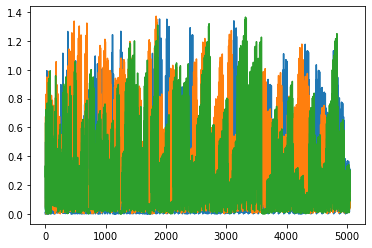

In [161]:
# generate X
X = np.random.rand(T, n)

# transform X
X_phi = np.zeros((int(T + (T * (T - 1) / 2)), p))

for i in range(n):
    X_phi[:, i] = _phi(X[:, i])

plt.plot(X_phi)
# generate W
W = np.random.rand(p, p)
# W = np.ones((n, n))

# transformed Y, add some noise.
noise_level = 0.00
Y_phi = X_phi @ W + noise_level * np.random.rand(int(T + (T * (T - 1) / 2)), p)

# get Gram matrix Psi for X_phi, get matrix K of X_phi and Y_phi
Psi = np.dot(X_phi.T, X_phi)
K = np.dot(X_phi.T, Y_phi)

# run Kernel OMP
print(f"Matrix W found using K-OMP: \n{np.round(KOMP_Psi_K(Psi, K), 2)}.")

# compare to original W
print(f"\nTrue Matrix:\n{np.round(W, 2)}.")

#### Results
We see that we can perfectly retrieve $W$ if we have no noise. The abstract question then is, what does this $W$ mean? Relations between $\phi(X)$ and $\phi(Y)$. However, what does this mean with respect to $X$ and $Y$. Hopefully, we can capture some non-linearity between $X$ and $Y$ using some kernel, but this remains to be seen.

We have $$\phi(Y) = \phi(X) W.$$

In the quadratic kernel case, we have that

$$\begin{pmatrix} \phi(Y_1) & \cdots & \phi(Y_p) \end{pmatrix} = \begin{pmatrix} \phi(X_1) & \cdots & \phi(X_p) \end{pmatrix} W.$$

$$\begin{pmatrix} Y_{11}^2 & \cdots & Y_{p1}^2  \\ 
                  Y_{12}^2 & \cdots & Y_{p2}^2  \\
                  \vdots & \vdots & \vdots \\
                  Y_{1T}^2 & \cdots & Y_{pT}^2  \\
                  \sqrt{2}Y_{11}Y_{12} & \cdots & \sqrt{2}Y_{p1}Y_{p2}  \\
                  \vdots & \vdots & \vdots \\
                  \sqrt{2}Y_{1,T-1}Y_{1T} & \cdots & \sqrt{2}Y_{p, T-1}Y_{pT}  \\
  \end{pmatrix} = \begin{pmatrix} X_{11}^2 & \cdots & X_{p1}^2  \\ 
                  X_{12}^2 & \cdots & X_{p2}^2  \\
                  \vdots & \vdots & \vdots \\
                  X_{1T}^2 & \cdots & X_{pT}^2  \\
                  \sqrt{2}X_{11}X_{12} & \cdots & \sqrt{2}X_{p1}X_{p2}  \\
                  \vdots & \vdots & \vdots \\
                  \sqrt{2}X_{1,T-1}X_{1T} & \cdots & \sqrt{2}X_{p, T-1}X_{pT}  \\
  \end{pmatrix} W.$$
  
For any matrix $W$, the right hand side gets incredibly distorted, with a sum of at most $p$ quadratic values of $X_{\cdot}$. This raises a difficult question, how can we transform this $Y_{11}^2 = \sum_{i=1}^p X_{1i}^2 w_{I1}$ back to $Y_{11}$? Is this even possible?

We can quite simply derive that what $Y$ should be, using the system of equations.

In [167]:
print(np.shape(Y_phi))
print(np.shape(X_phi))
print(f"Y_11 squared: {Y_phi[0][0]}.")
print(f"\sum_i^p X1i ^2 wi1: should be Y_11 squared: {(X_phi @ W)[0][0]}.")
print(f"|Y_11|: {np.sqrt(Y_phi[0][0])}.")
print(f"|Y_12|: {np.sqrt(Y_phi[1][0])}.\n")
print(f"\sqrt(2) Y_11 Y_12: {np.sqrt(2) * np.sqrt(Y_phi[0][0]) * np.sqrt(Y_phi[1][0])}.")
print(f"SHOULD be equal to \phi(Y_1)_T+1: {Y_phi[T][0]}.")
print("But is is not.")

print(f"Is equal to (phi(X) @ W)_1T+1: {(X_phi @ W)[T][0]}.")

total = 0

for i in range(p):
    total += np.sqrt(2) * X[0, i] * X[1, i] * W[i][0]

print(f"Manual Calculation: {total}.")

print(f"\nAnother: Should be Y_11: {np.sqrt(Y_phi[T][0] / (np.sqrt(2) * np.sqrt(Y_phi[1][0])))}.")

(5050, 3)
(5050, 3)
Y_11 squared: 0.3193510357986572.
\sum_i^p X1i ^2 wi1: should be Y_11 squared: 0.3193510357986572.
|Y_11|: 0.5651115250980617.
|Y_12|: 0.5311567745967837.

\sqrt(2) Y_11 Y_12: 0.42449432383447544.
SHOULD be equal to \phi(Y_1)_T+1: 0.4208712377244242.
But is is not.
Is equal to (phi(X) @ W)_1T+1: 0.4208712377244242.
Manual Calculation: 0.4208712377244242.

Another: Should be Y_11: 0.7485240558677219.


#### Conclusion 
We see that this transformation might make sense in the feature space $\Phi(\cdot)$. We can apply the kernel trick and use $\Phi(X)$ and $\Phi(Y)$ rather than $X$ and $Y$. However, it seems impossible (at least for this Kernel) to recover $Y$ from $\Phi(Y)$. It seems to be a linear combination of $\Phi(X)$, but it does not seem to be possible to recover our matrix $Y$. We need the inverse of the Kernel, so $\Phi^{-1}(Y)$. 

1 0
1 0
1 0


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

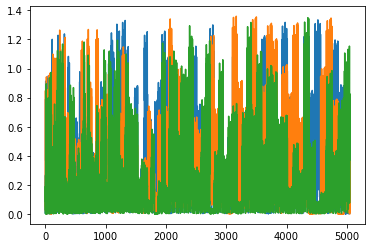

In [152]:
# generate X
X = np.random.rand(T, n)

# transform X
X_phi = np.zeros((int(T + (T * (T - 1) / 2)), p))

for i in range(n):
    X_phi[:, i] = _phi(X[:, i])

plt.plot(X_phi)
# generate W
w = np.random.rand(p)
# W = np.ones((n, n))

# transformed Y, add some noise.
noise_level = 0.00
Y_phi = X_phi @ w + noise_level * np.random.rand(int(T + (T * (T - 1) / 2)))

# get Gram matrix Psi for X_phi, get matrix K of X_phi and Y_phi
Psi = np.dot(X_phi.T, X_phi)
K = np.dot(X_phi.T, Y_phi)

# run Kernel OMP
print(f"Matrix W found using K-OMP: \n{np.round(KOMP_Psi_K(Psi, K), 2)}.")

# compare to original W
print(f"\nTrue Matrix:\n{np.round(W, 2)}.")

In [74]:
X = np.random.rand(T)

Y = X ** 2

for i in range(T):
    for j in range(i):
        Y += X[i] * X[j] * np.sqrt(2)
        
print(np.dot(X.T, X) ** 2)

print(np.dot(Y.T, Y))

1.847533992312714
249.86052266726932


[[62.19005806 61.31614147 61.26767232]
 [61.31614147 61.42436605 60.89910006]
 [61.26767232 60.89910006 61.38426054]]
[[8.07983607e+01 1.05687697e+00 1.37475243e-02]
 [1.05687697e+00 6.72750399e+01 2.88806007e-01]
 [1.37475243e-02 2.88806007e-01 6.46376230e+01]]
[[0.09916076 0.07823288 0.06189843]
 [0.04219759 0.04399092 0.04358898]
 [0.04702997 0.04109676 0.04809777]]


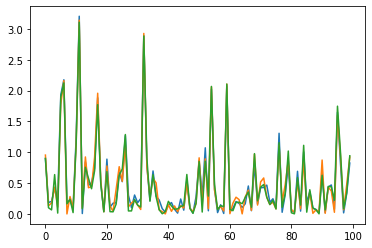

In [80]:
T = 100
d = 2

# Generate Data in some Quadratic Manner
X = np.random.rand(T, n)
X -= np.mean(X, axis = 0)

W = np.array(2 * np.ones(n ** 2)).reshape(n, n)

Y = np.zeros((T, n))

for t in range(T):
    Y[t] = X[t] ** 2
    
    for i in range(n):
        for j in range(n):
            Y[t] += np.sqrt(2) * X[t, i] * X[t, j]

print(np.dot(Y.T, Y))
print(np.dot(X.T, X) ** 2)

# Use Kernelized OMP to recover this nonlinear relationship
K = np.dot(X.T, Y) ** d
Psi = np.dot(X.T, X) ** d

print(np.round(KOMP_Psi_K(Psi, K), 10))

In [ ]:
### Instead of using the features (x1, ..., xn), try to use the features (xi^2, sqrt(2)xixj). 

In [77]:
def KOMP_Psi_K(Psi, K, max_coefs = 1e10, tol = 0.0, verbose = False, output = False, normalize = True):
    """Do Kernel OMP on X, Y."""
    
    # get dimensions
    T, n = np.shape(X)
    
    F = [i * (n + 1) for i in range(n)]

    # initialize Lambda, idx, betas
    Lambda, idx, betas = [[] for _ in range(n)], [], np.zeros((n, n))

    # compute norms if we want to normalize
    norms = [1] * n # initialize as harmless 1 array
    if normalize: norms = [np.linalg.norm(x) for x in X.T]
    
    # for each possible coefficient
    for i in range(n ** 2):    
    
        # compute gains
        gains = np.abs([(k - betas.T @ Psi[i, :]) / norms[i] for i, k in enumerate(K)])
        
        # set forbidden set to -1, impossible to pick then
#         gains = gains.flatten()
#         gains[F] = - np.ones(len(F))
#         gains = gains.reshape(n, n)
    
        # print(gains)
        
        # stopping criterion
        if np.round(gains, 5).max() <= tol: 
            print("Break")
            break
    
        # append best atom to Lambda
        # if tie, pick the one that minimizes residual
        row, col = np.argmax(gains) // n, np.argmax(gains) % n
        Lambda[col].append(row)
    
        # check if we have a DAG, not super efficient
        if True: # h.is_dag(Lambda_to_adj(Lambda)): 
            # update only column col, use indices of 
            idx = Lambda[col]
            Psi_F = Psi[np.array(idx)[:, None], np.array(idx)[None, :]]
        
            # update betas
            betas[np.array(idx)[:, None], col] = np.linalg.inv(Psi_F) @ K[np.array(idx)[:, None], col]
    
        else:
            # append forbidden entry to forbidden list
            F.append(int(np.argmax(gains)))
            # remove coefficient from Lambda
            Lambda[col].remove(row)
    
        # print info if verbose
        if verbose:
            print(f"Iteration {i + 1}.\n")
            print(f"Gains:\n{np.round(gains, 3)}.\n")
            print(f"Beta_{i + 1}:\n{np.round(betas, 3)}.\n")
            print(f"Residual Squared: {np.round([Theta[i] - Psi[:, i] @ betas[:, i] for i in range(n)], 32)}.\n\n")

    return betas 

In [ ]:
def KOMP_Psi_K_1D(Psi, K, max_coefs = 1e10, tol = 0.0, verbose = False, output = False, normalize = True):
    """Do Kernel OMP on X, Y."""
    
    # get dimensions
    T, n = np.shape(X)

    # initialize Lambda, idx, betas
    Lambda, idx, betas = [[] for _ in range(n)], [], np.zeros((n, n))

    # compute norms if we want to normalize
    norms = [1] * n # initialize as harmless 1 array
    if normalize: norms = [np.linalg.norm(x) for x in X.T]
    
    # for each possible coefficient
    for i in range(n ** 2):    
    
        # compute gains
        gains = np.abs([(K - betas.T @ Psi[i, :]) / norms[i] for i in range(N)])
        
        # set forbidden set to -1, impossible to pick then
#         gains = gains.flatten()
#         gains[F] = - np.ones(len(F))
#         gains = gains.reshape(n, n)
    
        # print(gains)
        
        # stopping criterion
        if np.round(gains, 5).max() <= tol: 
            print("Break")
            break
    
        # append best atom to Lambda
        # if tie, pick the one that minimizes residual
        row, col = np.argmax(gains) // n, np.argmax(gains) % n
        Lambda[col].append(row)
    
        # check if we have a DAG, not super efficient
        if True: # h.is_dag(Lambda_to_adj(Lambda)): 
            # update only column col, use indices of 
            idx = Lambda[col]
            Psi_F = Psi[np.array(idx)[:, None], np.array(idx)[None, :]]
        
            # update betas
            betas[np.array(idx)[:, None], col] = np.linalg.inv(Psi_F) @ K[np.array(idx)[:, None]]
    
        else:
            # append forbidden entry to forbidden list
            F.append(int(np.argmax(gains)))
            # remove coefficient from Lambda
            Lambda[col].remove(row)
    
        # print info if verbose
        if verbose:
            print(f"Iteration {i + 1}.\n")
            print(f"Gains:\n{np.round(gains, 3)}.\n")
            print(f"Beta_{i + 1}:\n{np.round(betas, 3)}.\n")
            print(f"Residual Squared: {np.round([Theta[i] - Psi[:, i] @ betas[:, i] for i in range(n)], 32)}.\n\n")

    return betas 